Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

STUDENT ID: 001130451

---

# Coursework Assignment (COMP 42315)

The assignment consists of 3 questions. You are required to implement the programming solution containing your code and written answers that explain the implementation and justify the design. For more details, refer to the assignment brief on Blackboard Ultra page 

https://blackboard.durham.ac.uk/ultra/courses/_54354_1/outline/file/_1723127_1

# Instructions (Question 1 and 2)

For Questions 1 and 2, you are asked to perform the following tasks based on the following target website, which contains artificial content designed for this assignment: https://sitescrape.awh.durham.ac.uk/comp42315/

# Question 1 (35 marks)

Please design and implement a solution to crawl the publication title, year and author list of every unique publication record on the target website. Then, please create and display a table that contains these unique records. The table should consist of five columns: the row number in the table, publication title, year, author list, and the number of authors (hint: you will need to develop an algorithm to work this out). The records should be sorted first according to descending year values, then by descending number of author values, and finally by the titles from A to Z. Include the full final result in your Jupyter Notebook. 

[Explain your design and highlight any features in this question’s report part of your Jupyter Notebook in no more than 300 words. (35%)]

### Write your code in the following space.

In [1]:
# importing necessary libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import csv
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, BicScore, BayesianEstimator, ExpectationMaximization, MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork, BayesianModel
from pgmpy.inference import VariableElimination
import networkx as nx
from IPython.core.display import display, HTML
from pgmpy.metrics.metrics import correlation_score, log_likelihood_score, structure_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


# Firstly, I create constants for URLs that I will also use in the Q2 
urlBase = "https://sitescrape.awh.durham.ac.uk/comp42315"
urlFirst = "https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_animationandgraphics.htm"

# Empty list for all topic page urls
urlTopics = []

# Now, I add the first topic page constant to the list
urlTopics.append(urlFirst)

# I parse the HTML content from the first page
page = requests.get(urlFirst, verify=True)
soup = BeautifulSoup(page.content, "html.parser")

# I find all classes "TextOption", but only select the second one
topicsoup = soup.find_all("p", class_="TextOption")[1]
for a in topicsoup.find_all("a", href=True):
    href = a['href']
    if not href.startswith('http'):  # This checks whether the href is a relative URL
        href = href.lstrip('/')  # This removes the leading slash if present
        topicUrl = f"{urlBase}/{href}"
    else:
        topicUrl = href  # Using the full URL if it's already complete

    if topicUrl not in urlTopics:
        urlTopics.append(topicUrl)
        
# Function to extract publication details 
def extract_publications(soup):
    publications = []
    unwanted_title_entries =  [
        "REF 2014 Submission", "REF 2021 Submission",
        "Best Poster Award", "Best Paper Award",
        "Oral Presentation", "Best Student Paper Award",
        "Invited presentation at Eurographics 2019",
        "IEEE CIS Outstanding Student-Paper Travel Grants" #as there are some unwanted text entries I don't want in my table
    ]
    
    for publication in soup.find_all('div', class_='w3-cell-row'): # extracting publication title
        title_unfiltered = publication.find('span', class_='PublicationTitle')
        if not title_unfiltered:
            continue
        title_text = title_unfiltered.text.strip()
        for unwanted in unwanted_title_entries:
            title_text = title_text.replace(unwanted, '').strip()

        # Extracting authors information and year
        text_small_elements = publication.find_all('span', class_='TextSmall')
        if not text_small_elements:
            continue
        authors = text_small_elements[1].text.split(',') # as authors are in the second 'TextSmall'
        
        # Here I am correcting the last entry in the authors list if it contains "and"
        if 'and' in authors[-1]:
            last_authors = authors[-1].split('and')
            authors = authors[:-1] + last_authors
    
        details = text_small_elements[0].text.split(',') # as year is in the first "TextSmall"
        year = next((int(detail.strip()) for detail in details if detail.strip().isdigit() and len(detail.strip()) == 4), None)

        publications.append({
            'title': title_text,
            'year': year,
            'authors': ', '.join(authors),
            'num_authors': len(authors) # to get the number of authors
        }) 

    return publications


# Function to display the table with styling
def display_table_enhanced(publications):
   if not publications:
        print("No publications data found.")
        return
   df = pd.DataFrame(publications)
   df = df.drop_duplicates() # deleting duplicate records
   df = df.sort_values(by=['year', 'num_authors', 'title'], ascending=[False, False, True]) # Sorting the entries in the table
   df.index = range(1, len(df) + 1)  # So the first position is no 1., not 0.

    # Improving visual aspects of the table with pandas styling
   styled_df = df.style.set_table_styles([
        {'selector': 'th', 'props': [('font-weight', 'bold')]},  # Bold headers
        {'selector': 'td', 'props': [('text-align', 'left')]},   # Aligning text to the left in text cells
        {'selector': 'th', 'props': [('text-align', 'left')]},   # Aligning text to the left in header cell
    ]).set_properties(**{'background-color': 'white', 'color': 'black'}) # Background colours
   return styled_df

# Collecting all publications from the every single topic URL
all_publications = []
for topicUrl in urlTopics:
    print(f"Scraping: {topicUrl}") #So it is displaying in the output which URL is being scraped right now
    try:
        response = requests.get(topicUrl)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            publications = extract_publications(soup)

SyntaxError: unexpected EOF while parsing (<ipython-input-1-010552a002ce>, line 120)

### Write your description in the following space.

This code was implemented taking into consideration handling possible errors, validation and the best visualisation of data from web scraping, also being user-friendly.

I tried to break down the code into specific functions such as "extract_publications", or "display_table_enhanced", so it is much easier to follow and possibly update. Each of the function covers different part of the process of this task, keeping in mind clean code organisation.

In "extract_publications" function I made sure to filter out the unwanted words that were appearing in the title entries, as well as non-author text. It was completed by implementing efficient text processing expressions. I decided to use r library for this purpose.

It was also difficult for me to get the proper way of displaying authors' names, and therefore the count of authors. It is because the last two authors names on the website are distinguished with "and", instead of a comma, and I had to add a snippet that fixes it. 

At the end, in "display_table_enhanced" I am using Pandas library to create a nicely looking styled DataFrame, which displays publications with their year, number of authors, names of authors and titles.


# Question 2 (30 marks)

For this question, you should record the year, number of citations, topic, and number of Links, Downloads, and Online Resources (LDOR) for each journal paper listed on the scraping website and store these in a dataframe. Take care to filter the elements for uniqueness before producing the analysis. Produce a table showing the mean and variance of citations per journal publication in each topic and print it legibly in your submission. In Figure 1, you should show the mean and variance of citations per year across all journal publications for each topic. In Figure 2, you should show the number of LDOR against the number of citations for each journal publication. Each figure should be legible and have appropriate labels. 

[Explain your design and highlight any features in this question’s report part of your Jupyter Notebook in no more than 300 words. (30%)]

### Write your code in the following space.

In [2]:
# Function to get a number of LDOR
def get_ldor_count(soup):
    ldor_count = 0
    ldor_section = soup.find('h2', string=lambda t: t and "Links, Downloads and Online Resources" in t)
    if ldor_section:
        container = ldor_section.find_next_sibling()
        ldor_count += len(container.find_all('a', recursive=False))
    video_containers = soup.find_all('div', style=lambda value: value and 'position:relative;' in value)
    # it was not counting video numbers appropriately, so this snippet was added:
    for video_container in video_containers:
        ldor_count += len(video_container.find_all('iframe', recursive=False))
    return ldor_count

# Function to extract all the details needed for the dataframe: year, no of citations, no of ldor and topic name
def extract_details(soup, topic_url):
    # Extract year
    yeartext = soup.text
    yearmatch = re.search(r'\b\d{4}\b', yeartext) # searching for the corrector format of year using regular expression
    year = yearmatch.group(0) if yearmatch else 'N/A'

    # Extract number of citations
    citation_element = soup.find('span', style="color:orange; font-size:16px;")
    if citation_element:  # This checks if the element was found
        citation_text = citation_element.text
        citation_match = re.search(r'\d+', citation_text) # regular expression to find citations
        citations = int(citation_match.group()) if citation_match else 0
    else:
        citations = 0  # In case there are no citations

    # Extract LDOR count
    ldor_count = get_ldor_count(soup)

    return year, citations, ldor_count

def normalize_url(url):
    # Normalize the URL for consistency
    return url.strip('/').lower()

# Function to scrape journal papers from every topic page
def scrape_publications_from_topic(topic_url):
    response = requests.get(topic_url, verify=True)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Initialize a list to hold tuples of (publication_url, topic_name)
    publications_with_topics = []

    # Find the journal section and extract URLs if present
    journal_section = soup.find('h2', id='Journal Papers')
    if journal_section:
        # Extract the correct topic name from the page URL
        topic_name = topic_url.split('_')[-1].split('.')[0]  # This gets the 'something' part from 'publicationfull_type_something.htm'

        for sibling in journal_section.find_next_siblings():
            if sibling.name == "h2":
                break  # Stop if it reaches another heading
            for link in sibling.find_all('a', href=True):
                if 'pbl_' in link['href']:
                    pub_full_url = urlBase + '/' + link['href'].lstrip('/')
                    # Normalize the URL before adding to ensure the uniqueness
                    normalized_url = normalize_url(pub_full_url)
                    if normalized_url not in publications_with_topics:
                        publications_with_topics.append((normalized_url, topic_name))
    else:
        print(f"No journal section found in {topic_url}") # If in the section there are no journal publications found

    return publications_with_topics

# Parsing the first topic page to find other topic URLs
page = requests.get(urlFirst, verify=True)
soup = BeautifulSoup(page.content, "html.parser")
topicsoup = soup.find_all("p", class_="TextOption")
for ts in topicsoup:
    for a in ts.find_all("a", href=True):
        href = a['href']
        if not href.startswith('http'):
            href = urlBase + '/' + href.lstrip('/')
        if href not in urlTopics:
            urlTopics.append(href)

# Initialising a DataFrame
df = pd.DataFrame(columns=['Year', 'Citations', 'Topic', 'LDOR Count'])
data_rows = []

# Iterate over each topic URL to collect publications
for topicUrl in urlTopics:
    if "publicationfull_type_" in topicUrl:
        publications_with_topics = scrape_publications_from_topic(topicUrl)
        print(f"Scraping publications from {topicUrl}") # So the output shows which URL is being scraped from currently
        for full_url, topic_name in publications_with_topics:
            response = requests.get(full_url, verify=True)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                year, citations, ldor_count = extract_details(soup, full_url)
                data_rows.append({'Year': year, 'Citations': citations, 'Topic': topic_name, 'LDOR Count': ldor_count})
            else:
                print(f"Failed to retrieve publication from {full_url}")
    else:
        print(f"Skipping non-journal URL: {topicUrl}") # If there are no journal papers at the specific URL

# Since all the data rows are collected, they are added to the DataFrame
if data_rows:
    df = pd.DataFrame(data_rows)
    # Using inplace=True without reassigning df
    df.drop_duplicates(inplace=True)
    df.index = range(1, len(df) + 1)

    styled_df = df.style.background_gradient()
    display(styled_df) # printing the table
else:
    print("No publications to display.")

Scraping publications from https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_animationandgraphics.htm
Scraping publications from https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_movementevaluation.htm
Scraping publications from https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_biomedicalengineering.htm
Scraping publications from https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_interactionmodelling.htm
Scraping publications from https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_others.htm
Scraping publications from https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_actionrecognition.htm
Scraping publications from https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_depthand3destimation.htm
Scraping publications from https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_virtualreality.htm
Scraping publications from https://sitescrape.awh.durham.ac.uk/comp42315

,Year,Citations,Topic,LDOR Count
1,2023,2,animationandgraphics,4
2,2022,9,animationandgraphics,4
3,2021,68,animationandgraphics,4
4,2021,16,animationandgraphics,5
5,2019,5,animationandgraphics,4
6,2015,25,animationandgraphics,4
7,2014,7,animationandgraphics,4
8,2013,26,animationandgraphics,5
9,2013,2,animationandgraphics,4
10,2012,48,animationandgraphics,7


In [3]:
# part 2 of Q2 - mean and variance

# Grouping data by topic and calculating mean and variance of citations
grouped = df.groupby('Topic')['Citations'].agg(['mean', 'var']).reset_index()

# Renaming columns to make it look nicer 
grouped.columns = ['Topic', 'Mean of Citations', 'Variance of Citations']

grouped.index = range(1, len(grouped) + 1) # so the first record is 1., not 0.

grouped

,Topic,Mean of Citations,Variance of Citations
1,3dsurfaces,13.400000,74.800000
2,actionrecognition,35.000000,1289.000000
3,animationandgraphics,25.666667,842.787879
4,biomedicalengineering,33.900000,2448.100000
5,biometrics,16.375000,313.982143
6,computationalintelligence,18.000000,223.000000
7,crowdsimulation,15.400000,139.300000
8,depthand3destimation,59.400000,4432.800000
9,facialfeatureanalysis,10.000000,74.500000
10,handmodelling,5.333333,2.333333


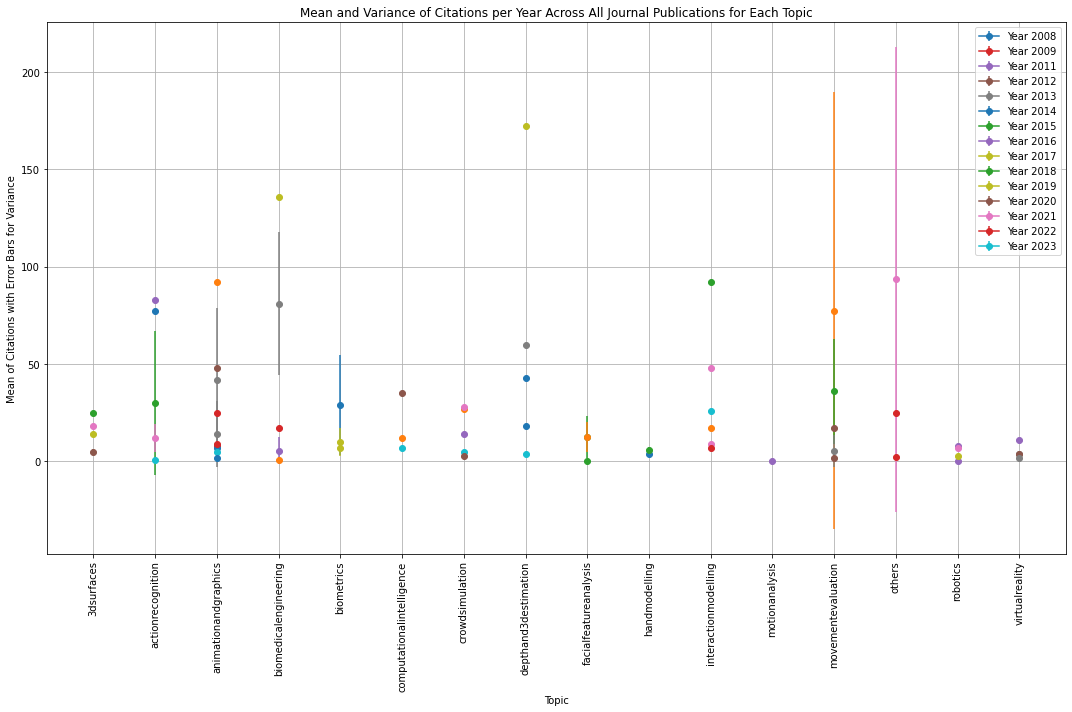

In [4]:
# figure 1 - Q2

grouped_year_topic = df.groupby(['Year', 'Topic']).agg(mean=('Citations', 'mean'), var=('Citations', 'var')).reset_index()

# Unique years and topics for plotting
years = sorted(grouped_year_topic['Year'].unique())
topics = sorted(grouped_year_topic['Topic'].unique())

# Setting the figure size to make it larger so the labels are fully visible 
plt.figure(figsize=(15, 10))

# Plotting each year separately
for year in years:
    year_data = grouped_year_topic[grouped_year_topic['Year'] == year]
    for topic in topics:
        topic_data = year_data[year_data['Topic'] == topic]
        if not topic_data.empty:
            mean_citations = topic_data['mean'].values[0]
            var_citations = topic_data['var'].values[0] if not np.isnan(topic_data['var'].values[0]) else 0
            std_citations = np.sqrt(var_citations)  # Since standard deviation is the square root of variance
            plt.errorbar(topics.index(topic), mean_citations, yerr=std_citations, fmt='-o', label=f'Year {year}')

# Creating a custom legend for the figure 1 without duplicates
handles, labels = plt.gca().get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
plt.legend(*zip(*unique))

plt.title('Mean and Variance of Citations per Year Across All Journal Publications for Each Topic')
plt.xlabel('Topic')
plt.ylabel('Mean of Citations with Error Bars for Variance') # adding title, x-axis label and y-axis label
plt.xticks(ticks=range(len(topics)), labels=topics, rotation=90)  # Set the x-ticks to match the topics
plt.grid(True)
plt.tight_layout()  # Adjusting layout so no element is cut off
plt.show()   

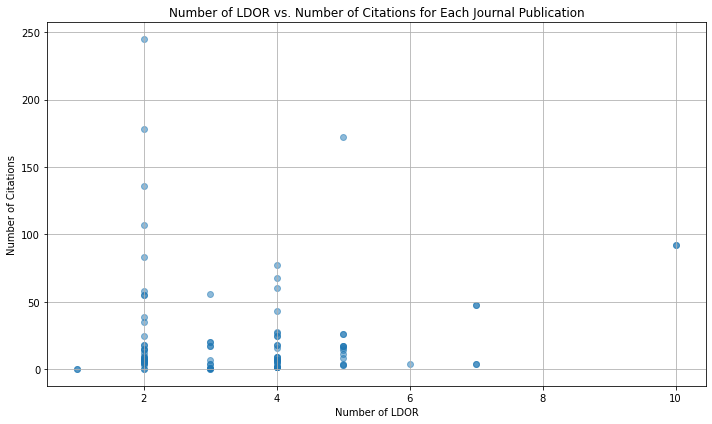

In [5]:
# figure 2 - Q2

plt.figure(figsize=(10, 6))
plt.scatter(df['LDOR Count'], df['Citations'], alpha=0.5)  # Alpha is used for transparency

plt.title('Number of LDOR vs. Number of Citations for Each Journal Publication')
plt.xlabel('Number of LDOR')
plt.ylabel('Number of Citations') # adding the title of the table, label on x-axis and y-axis
plt.grid(True)
plt.tight_layout()
plt.show()


### Write your description in the following space.

I firstly created a code to create a required dataframe, which I struggled with because videos attached to certain publications were not counting towards LDOR count correctly, and this is why I had to implement changes in the get_ldor_count(soup) function.

The code constructs two figures from a dataset of academic publications. The first figure is a multi-year trend graph that shows the mean and variability of citations per topic using error bars to represent standard deviation, which is calculated from the variance. The errorbar plot is indexed by the position of each topic within a sorted list, ensuring accurate x-axis placement. I customised the legend, which prevents label duplication by only including the first occurence of each year. 

The second figure is a scatter plot examining the relationship between the number of LDOR and citation counts. 
I included transparency, by adding the alpha parameter to help with discerning data points in concentrated places.
Both figures are created using matplotlib library, in order to achieve clear and concise visualisation, and are also grid-enabled to achieve better readibility of data points. The code's design emphasizes interpretability and clean presentation of data insights.

# Instructions (Question 3)

For Question 3, you are asked to perform the task based on the target dataset (finance_dataset.csv), which you can download separately on Blackboard Ultra (refer link below). The file contains artificial content designed for this assignment.

https://blackboard.durham.ac.uk/ultra/courses/_54354_1/outline/file/_1723128_1

DO NOT CHANGE THE FILE NAME FOR THE CONSIDERED DATASET

# Question 3 (35 marks)

The Cross-Sectional Asset Pricing dataset includes 210 features. The target variable is 'excessret', a firm's excess return between the current and the previous quarter. You are required to work on a subset that includes the 'defined features' and the 'target variable' by performing preprocessing (in the subset, there will be 11 features in total including target variable). You are required to extract the 'defined features' that are as indicated below: 

defined_columns = ['high52', 'mom12m', 'mom6m', 'maxret', 'mom12moffseason', 'realizedvol', 'idiovolaht', 'zerotrade', 'indretbig', 'returnskew']

Design and implement the solution to analyze the complex relationship between defined features and the firm's excess return between the current and the previous quarter. Highlight and visualise the attributes with the highest probabilistic relationship with the target variable. Justify the design choice and showcase the findings using an appropriate visualisation tool. 

[Explain your design and highlight any features in this question's report part of your Jupyter Notebook in no more than 400 words. (35%)]


### Write your code in the following space.

In [6]:
# Opening the dataset

open('finance_dataset.csv', mode = 'r')  #dataset is already in the .csv format so we don't need to parse it

# now im displaying first 5 rows of the dataset

df = pd.read_csv('finance_dataset.csv')
df.head()

,permno,yyyymm,am,aop,abnormalaccruals,accruals,accrualsbm,activism1,activism2,adexp,...,sinalgo,skew1,std_turn,tang,zerotrade,zerotradealt1,zerotradealt12,ret,rf,excessret
0,15069.0,200304,2.286007,0.536846,-0.006326,0.114091,0.0,14.0,9.649775,0.029112,...,0.0,-0.059005,-0.104150,0.761250,2.166704e-08,1.806914e-08,2.194579e-08,-0.050063,0.000939,-0.051002
1,11599.0,200304,1.145382,0.118182,-0.052503,0.024321,1.0,17.0,12.253696,0.178918,...,0.0,-0.058781,-0.028150,0.760054,1.539724e-07,1.344081e-07,1.347822e-07,0.073944,0.000939,0.073005
2,14008.0,200304,0.081509,-0.456790,-0.022882,0.024184,0.0,15.0,0.000000,0.012397,...,0.0,-0.044184,-0.050250,0.756780,1.070238e-08,1.103195e-08,8.583374e-09,0.065161,0.000939,0.064222
3,10342.0,200304,0.480549,-1.659227,-0.031106,0.034601,0.0,11.0,10.047029,0.008054,...,0.0,-0.143605,-0.017385,0.298265,1.178551e-08,8.586766e-09,1.030102e-08,0.042494,0.000939,0.041555
4,11775.0,200304,3.689301,0.113271,-0.089644,0.180396,1.0,17.0,9.502643,0.222213,...,1.0,-0.084900,-0.056594,0.760054,4.140273e-08,3.211832e-08,2.725901e-08,0.148315,0.000939,0.147376


In [7]:
# creating a subset with 10 desired variables and one target variable
desired_columns = ['high52', 'mom12m', 'mom6m', 'maxret', 'mom12moffseason', 'realizedvol',
                   'idiovolaht', 'zerotrade', 'indretbig', 'returnskew']

subset = desired_columns + ['excessret']
subset_df = df[subset]
subset_df.describe().transpose()

# dealing with any missing values 
subset_df = subset_df.fillna(subset_df.median())

# dividing the subset into testing and training sets 
X = subset_df.drop(columns=['excessret'])
y = subset_df['excessret']   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20) #default split is 75%

# training it using linear regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# printing the intercept and coefficients
print (linreg.intercept_)
print(linreg.coef_)

# pair the feature names with the coefficients
zip(X, linreg.coef_)

-0.35319514631909077
[ 0.38743326 -0.08179203 -0.06323792 -3.23160666 -0.5862193   5.5455078
 -2.95658095 -0.18155319 -0.05397804  0.02047035]


In [8]:
# making predictions 
X_test.loc[2]
# make predictions on the testing set
y_pred = linreg.predict(X_test)
print(y_pred)

[-0.0370748   0.27202967  0.07107854  0.05521189  0.01936957  0.35448328
  0.02508045 -0.00542275  0.07741901  0.10536067 -0.01586483  0.05178034
  0.02458087 -0.03494614  0.06385136  0.1130623   0.0325315   0.05877461
  0.08605137  0.02659636  0.0547317   0.05816211  0.13504754  0.02241505
  0.05097995  0.0609296   0.06192622  0.31824425  0.11577712  0.07176776
  0.03862066  0.18166648  0.14236804  0.0910702   0.0915026   0.03346822
  0.24245731  0.17262452  0.10810329  0.13876374  0.08306535  0.04954885
  0.02077564  0.0894075   0.00448401  0.12496884  0.00470065  0.03445458
  0.08327737  0.07987467  0.05147195  0.02299187 -0.00102253 -0.04224642
  0.06484817  0.12800919  0.21241681 -0.0059032   0.05241621  0.08837115
  0.00612964 -0.0455652   0.05593168  0.28645362  0.09929828 -0.01367638
  0.03842586  0.04241976  0.32115149  0.01505982  0.01980268 -0.02681022
  0.06601765  0.18655965  0.03126372  0.03396697  0.58638334  0.01790919
  0.08584385  0.00305305 -0.01221516  0.03308758  0

In [9]:
# function to discretize dataframe before Bayesian Network
def make_discrete(df):
    discrete_df = pd.DataFrame()

    # Creating bins based on the quartiles points of every variable, I decided to use 5 bins for every variable
    high52_bins = [df['high52'].min(), 0.7080895, 0.8573567, 0.9437912, df['high52'].max()]
    mom12m_bins = [df['mom12m'].min(), -0.2476829, -0.06681741, 0.1125461, df['mom12m'].max()]
    mom6m_bins = [df['mom6m'].min(), -0.04321944, 0.06338909, 0.2279047, df['mom6m'].max()]
    maxret_bins = [df['maxret'].min(), -0.06634666, -0.04352695, -0.03118531, df['maxret'].max()]
    mom12moffseason_bins = [df['mom12moffseason'].min(), -0.005117328, 0.01181651, 0.03721887, df['mom12moffseason'].max()]
    realizedvol_bins = [df['realizedvol'].min(), -0.028479, -0.02097717, -0.01539543, df['realizedvol'].max()]
    idiovolaht_bins = [df['idiovolaht'].min(), -0.03273918, -0.0230339, -0.0173572, df['idiovolaht'].max()]
    zerotrade_bins = [df['zerotrade'].min(), 1.148040e-08, 1.827145e-08, 2.750040e-08, df['zerotrade'].max()]
    indretbig_bins = [df['indretbig'].min(), 0.008375047, 0.03814942, 0.07783812, df['indretbig'].max()]
    returnskew_bins = [df['returnskew'].min(), -0.6019183, -0.2079657, 0.1627917, df['returnskew'].max()]
    excessret_bins = [df['excessret'].min(), -0.00402, 0.049386, 0.1176867, df['excessret'].max()]
    
    # Labels for the discretization bins
    quartile_labels = ['Q1', 'Q2', 'Q3', 'Q4']

    # Since the number of bins is the same for all the variables, I used the same labels for all
    high52_labels = quartile_labels
    mom12m_labels = quartile_labels
    mom6m_labels = quartile_labels
    maxret_labels = quartile_labels
    mom12moffseason_labels = quartile_labels
    realizedvol_labels = quartile_labels
    idiovolaht_labels = quartile_labels
    zerotrade_labels = quartile_labels
    indretbig_labels = quartile_labels
    returnskew_labels = quartile_labels
    excessret_labels = quartile_labels

    # Applying the discretization using bins and their corresponding labels
    discrete_df['high52'] = pd.cut(df['high52'], bins=high52_bins, labels=high52_labels, include_lowest=True)
    discrete_df['mom12m'] = pd.cut(df['mom12m'], bins=mom12m_bins, labels=mom12m_labels, include_lowest=True)
    discrete_df['mom6m'] = pd.cut(df['mom6m'], bins=mom6m_bins, labels=mom6m_labels, include_lowest=True)
    discrete_df['maxret'] = pd.cut(df['maxret'], bins=maxret_bins, labels=maxret_labels, include_lowest=True)
    discrete_df['mom12moffseason'] = pd.cut(df['mom12moffseason'], bins=mom12moffseason_bins, labels=mom12moffseason_labels, include_lowest=True)
    discrete_df['realizedvol'] = pd.cut(df['realizedvol'], bins=realizedvol_bins, labels=realizedvol_labels, include_lowest=True)
    discrete_df['idiovolaht'] = pd.cut(df['idiovolaht'], bins=idiovolaht_bins, labels=idiovolaht_labels, include_lowest=True)
    discrete_df['zerotrade'] = pd.cut(df['zerotrade'], bins=zerotrade_bins, labels=zerotrade_labels, include_lowest=True)
    discrete_df['indretbig'] = pd.cut(df['indretbig'], bins=indretbig_bins, labels=indretbig_labels, include_lowest=True)
    discrete_df['returnskew'] = pd.cut(df['returnskew'], bins=returnskew_bins, labels=returnskew_labels, include_lowest=True)
    discrete_df['excessret'] = pd.cut(df['excessret'], bins=excessret_bins, labels=excessret_labels, include_lowest=True)

    return discrete_df


# Applying the discretization
cat_df = make_discrete(subset_df)

for column in cat_df:
    print(cat_df.groupby(column)[column].count().reset_index(name='Count').to_dict(orient='records'))

# Splitting the data into training and testing sets
training_data, testing_data = train_test_split(cat_df, test_size=0.2, random_state=20)

[{'high52': 'Q1', 'Count': 125}, {'high52': 'Q2', 'Count': 125}, {'high52': 'Q3', 'Count': 125}, {'high52': 'Q4', 'Count': 125}]
[{'mom12m': 'Q1', 'Count': 125}, {'mom12m': 'Q2', 'Count': 125}, {'mom12m': 'Q3', 'Count': 125}, {'mom12m': 'Q4', 'Count': 125}]
[{'mom6m': 'Q1', 'Count': 125}, {'mom6m': 'Q2', 'Count': 125}, {'mom6m': 'Q3', 'Count': 125}, {'mom6m': 'Q4', 'Count': 125}]
[{'maxret': 'Q1', 'Count': 125}, {'maxret': 'Q2', 'Count': 125}, {'maxret': 'Q3', 'Count': 125}, {'maxret': 'Q4', 'Count': 125}]
[{'mom12moffseason': 'Q1', 'Count': 125}, {'mom12moffseason': 'Q2', 'Count': 125}, {'mom12moffseason': 'Q3', 'Count': 125}, {'mom12moffseason': 'Q4', 'Count': 125}]
[{'realizedvol': 'Q1', 'Count': 125}, {'realizedvol': 'Q2', 'Count': 125}, {'realizedvol': 'Q3', 'Count': 125}, {'realizedvol': 'Q4', 'Count': 125}]
[{'idiovolaht': 'Q1', 'Count': 125}, {'idiovolaht': 'Q2', 'Count': 125}, {'idiovolaht': 'Q3', 'Count': 125}, {'idiovolaht': 'Q4', 'Count': 125}]
[{'zerotrade': 'Q1', 'Count':

In [10]:
hc = HillClimbSearch(data=training_data)
estimate = hc.estimate(scoring_method="k2score", max_iter=14.0, show_progress=True)

  0%|          | 0/14 [00:00<?, ?it/s]

In [11]:
# building the bayesian network
model = BayesianNetwork(estimate)

# disable text wrapping in output cell
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

model.cpds = []

model.fit(data=training_data,
          estimator=BayesianEstimator,
          prior_type="BDeu",
          complete_samples_only=True)

model.fit

<bound method BayesianNetwork.fit of <pgmpy.models.BayesianNetwork.BayesianNetwork object at 0x7fe51ca2e760>>

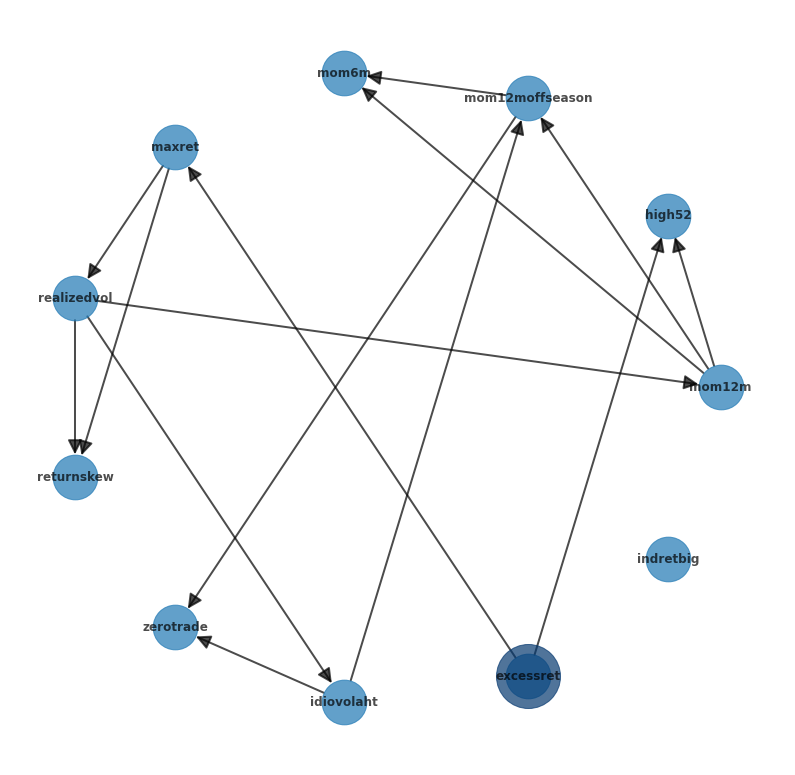

In [12]:
# plotting the graph
plt.figure(3,figsize=(14,14))
G = nx.DiGraph()
G.add_edges_from(model.edges)

G.add_nodes_from(model.nodes)
pos = nx.circular_layout(G)
DAG = G.to_directed()
nx.topological_sort(DAG)
nx.draw_networkx(G,
                pos=pos,
                with_labels=True,
                node_size=2000,
                arrowsize=30,
                alpha=0.7,
                font_weight="bold",
                width=2.0)

tt_g = G.subgraph(nodes=['excessret'])
nx.draw(tt_g, pos=pos, with_labels=False, arrowsize=0, node_size=4100, alpha=0.7, font_weight="bold", node_color="#063970")

plt.show()

In [13]:
# cpts tables
print(f'Check model: {model.check_model()}\n')
for cpd in model.get_cpds():
  print(f'CPT of {cpd.variable}:')
  print(cpd * 100, '\n')

Check model: True

CPT of high52:
+------------+--------------------+-----+---------------------+
| excessret  | excessret(Q1)      | ... | excessret(Q4)       |
+------------+--------------------+-----+---------------------+
| mom12m     | mom12m(Q1)         | ... | mom12m(Q4)          |
+------------+--------------------+-----+---------------------+
| high52(Q1) | 98.23943661971832  | ... | 0.40453074433656955 |
+------------+--------------------+-----+---------------------+
| high52(Q2) | 0.5868544600938966 | ... | 0.40453074433656955 |
+------------+--------------------+-----+---------------------+
| high52(Q3) | 0.5868544600938966 | ... | 5.582524271844661   |
+------------+--------------------+-----+---------------------+
| high52(Q4) | 0.5868544600938966 | ... | 93.6084142394822    |
+------------+--------------------+-----+---------------------+ 

CPT of mom12m:
+-------------+--------------------+-----+--------------------+
| realizedvol | realizedvol(Q1)    | ... | realizedvo

In [14]:
# scoring the model
accuracy_dict = {}

for column in testing_data:
  predict_data = testing_data.copy()
  predict_data.drop(column, axis=1, inplace=True)
  y_pred=model.predict(predict_data)

  accuracy = accuracy_score(testing_data[column], y_pred)
  print(f'{column} Accuracy score: {accuracy}')
  accuracy_dict[column] = accuracy

  0%|          | 0/100 [00:00<?, ?it/s]

high52 Accuracy score: 0.63


  0%|          | 0/100 [00:00<?, ?it/s]

mom12m Accuracy score: 0.74


  0%|          | 0/100 [00:00<?, ?it/s]

mom6m Accuracy score: 0.51


  0%|          | 0/100 [00:00<?, ?it/s]

maxret Accuracy score: 0.68


  0%|          | 0/100 [00:00<?, ?it/s]

mom12moffseason Accuracy score: 0.57


  0%|          | 0/100 [00:00<?, ?it/s]

realizedvol Accuracy score: 0.69


  0%|          | 0/100 [00:00<?, ?it/s]

idiovolaht Accuracy score: 0.56


  0%|          | 0/100 [00:00<?, ?it/s]

zerotrade Accuracy score: 0.31


  0%|          | 0/100 [00:00<?, ?it/s]

indretbig Accuracy score: 0.18


  0%|          | 0/100 [00:00<?, ?it/s]

returnskew Accuracy score: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

excessret Accuracy score: 0.47


In [15]:
# scoring the model continued
f1 = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=f1_score, return_summary=False)
acc = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=accuracy_score, return_summary=False)
pr = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=precision_score, return_summary=False)
recall = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=recall_score, return_summary=False)
ls = log_likelihood_score(model=model, data=testing_data)
ss = structure_score(model=model, data=testing_data, scoring_method='bdeu')

print(f'F1 score: {f1}')
print(f'Accuracy score: {acc}')
print(f'Precision score: {pr}')
print(f'Recall score: {recall}')
print(f'Log-likelihood score: {ls}')
print(f'Structure score: {ss}')

F1 score: 0.5714285714285715
Accuracy score: 0.7272727272727273
Precision score: 1.0
Recall score: 0.4
Log-likelihood score: -1268.129300975743
Structure score: -1467.525558957718


### Write your description in the following space.

I decided to use Bayesian Network in this analysis, as it is a good choice to spot the probabilistic relationships between 'defined features' and a firm's excess returns (target variable). Bayesian Networks are particularly good for this task due to their ability to capture complex dependencies.

In the created network, 'high52' and 'maxret' show as the attributes with the highest correlation to the target variable, indicating these factors are potentially strong predictors of excess returns. This insight is valuable for financial analysis and investment strategy formulation.

The model's performance, with an accuracy of 0.72 and perfect precision (1.0), indicates it is reliable in its predictions. However, the opportunity to improve the F1 score suggests that future iterations could enhance the model's ability to identify all relevant cases.

For visualization, a graph from the Bayesian Network can show the strength of the connections, with the edges between 'high52', 'maxret', and 'excessret' being highlighted to reflect their importance. This visual tool effectively communicates the probabilistic relationships and the model's findings in a concise and interpretable manner.